# Imports

In [0]:
from __future__ import unicode_literals
from spacy.en import English

In [0]:
nlp = English()

In [0]:
import json
from collections import defaultdict

In [0]:
import networkx as nx

Couldn't import dot_parser, loading of dot files will not be possible.


In [0]:
import pydot
from IPython.display import Image

# Utils

In [0]:
def build_dep_graph(tokens):
    dg = nx.DiGraph()
    for t in tokens:
        dg.add_node(t, label=t.string, ner=t.ent_type_, pos=t.pos_)
    deps = []
    for t in tokens:
        if t.dep_ == 'prep':
            dep = t.dep_ + '_' + t.lower_
        else:
            dep = t.dep_
        deps.append((t.head, t, dep) )
    sorted_deps = sorted(deps, key=lambda x: x[0])
    for gov, dep, rel in sorted_deps:
        dg.add_edge(gov, dep, label=rel)
    #for e in dg.selfloop_edges():
    #    dg.remove_edge(*e)
    return dg

In [0]:
def display_parse(dep_graph, filename):
    pdg = pydot.Dot()
    for u,v in dep_graph.edges():
        ulabel = '{lemma}-{index}'.format(lemma=u.lemma_, index=u.i)
        vlabel = '{lemma}-{index}'.format(lemma=v.lemma_, index=v.i)
        pdg.add_edge(pydot.Edge(ulabel,vlabel,**dep_graph.edge[u][v]))
    pdg.write_png('images/'+filename+'.png', prog='dot')
    pdg.write_dot('images/'+filename+'.dot', prog='dot')

In [0]:
def subtree_to_string(head, dg):
    others = [d for d in nx.algorithms.descendants(dg, head) if dg[head].get(d,{'label':''})['label'] != 'case'] 
    linearized = sorted([head,] + others, key=lambda x: x.i)
    return ' '.join([t.orth_ for t in linearized])

def simple_pas(predicate, dg):
    arguments = dg[predicate]
    _pas = defaultdict(list)
    for arg, rel in arguments.items():
        _pas[rel['label']].append(subtree_to_string(arg, dg))
    _pas[u'predicate'] = predicate.orth_
    return dict(_pas)

def collect_all_predicates(dg):
    dg.remove_edges_from(dg.selfloop_edges())
    predicates = [n for n in nx.topological_sort_recursive(dg) if n.pos_.startswith('V')]
    return [simple_pas(p, dg) for p in predicates]

# Examples

In [0]:
simple = "From 1981 to 1983, Vicki served as an assistant city representative at the National Center for Municipal Development."
copula = "She was the assistant to the executive director of the Democratic Study Group in the US House of Representatives from 1979 to 1981."
twoverb = "Vicki has also served as a government relations consultant, representing the interests of Portland, Oregon in Washington DC."
smallclause = "The Department of Agriculture had appointed Vicki president"
relclause_subj = "The clients whom Vicki has represented include Coca-Cola, Texaco, and Giant Foods."
subclause = "Vicki lobbied for health insurance companies that supported Obamacare"
passive = "Giant is represented by Victoria Cram as of June 3, 2006."

## simple

In [0]:
simple_dg = build_dep_graph(nlp(simple))

In [0]:
collect_all_predicates(simple_dg)

[{u'nsubj': [u'Vicki'],
  u'predicate': u'served',
  u'prep_as': [u'as an assistant city representative at the National Center for Municipal Development'],
  u'prep_from': [u'From 1981 to 1983'],
  u'punct': [u',', u'.']}]

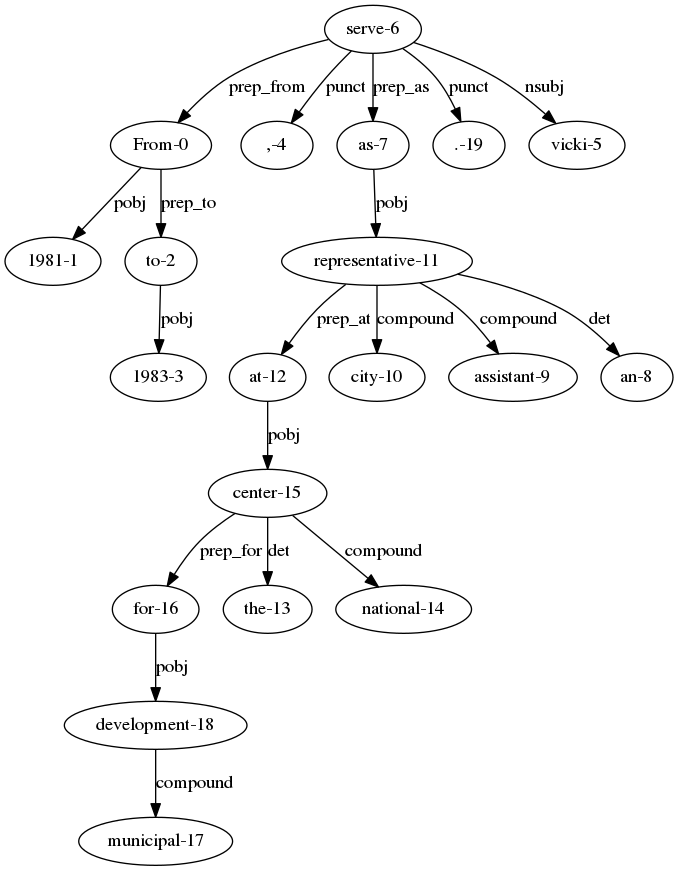

In [0]:
display_parse(simple_dg, 'spacy_simple_eg')
Image('images/spacy_simple_eg.png')

## Copula

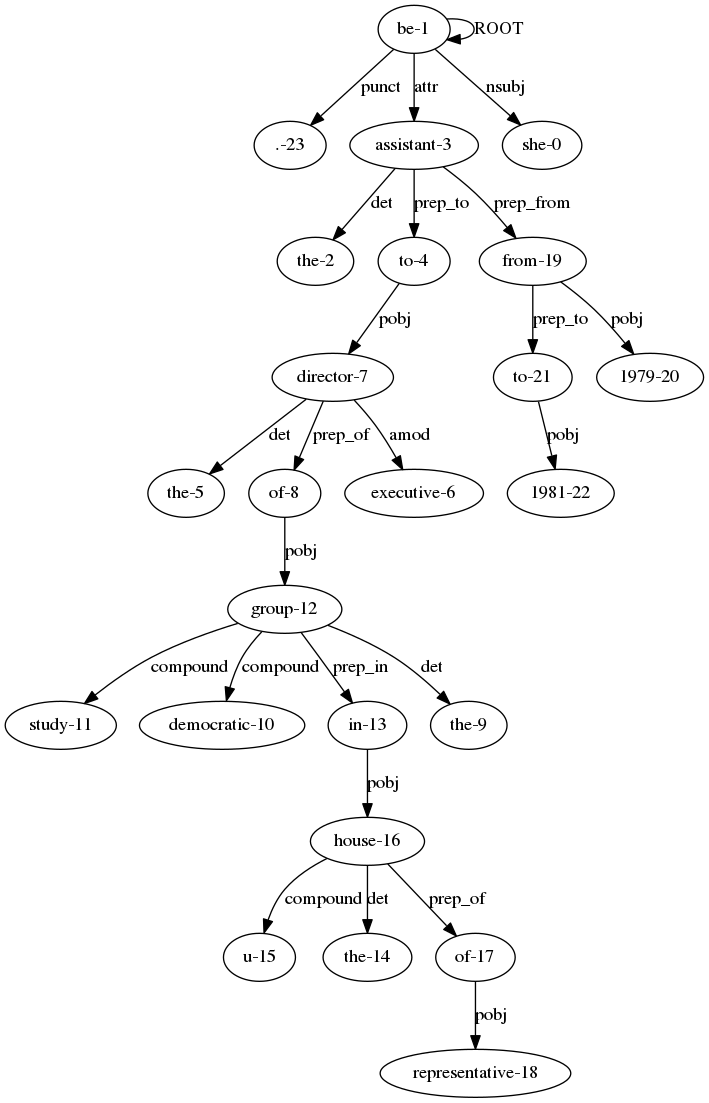

In [0]:
display_parse(build_dep_graph(nlp(copula)), 'spacy_copula_eg')
Image('images/spacy_copula_eg.png')

# Test

In [0]:
nlp = English()

In [0]:
manatt_data = json.load(open('data/manatt-out-html-full.json'))